In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [ ]:
print(train_images.shape,test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [ ]:
classes=len(np.unique(train_labels))

X_train = train_images.reshape(train_images.shape[0], 28, 28, 1)
X_test = test_images.reshape(test_images.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
y_train = keras.utils.to_categorical(train_labels, classes)
y_test = keras.utils.to_categorical(test_labels, classes)


### Define Evaluation metrics & Helper Functions

In [ ]:
import keras.backend as K

Using TensorFlow backend.


In [ ]:
from sklearn.metrics import *

In [ ]:
# for visualizing the training progress of our models
%matplotlib inline
import matplotlib.pyplot as plt
def viz_history(hs_dict,metric):
  plt.style.use('dark_background')
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.rcParams['font.size'] = 16
  plt.clf()
  for model in hs_dict.keys():
    plt.plot(hs_dict[model].history[metric],label='{0:s} train {1:s}'.format(model, metric))
    plt.plot(hs_dict[model].history['val_{0:s}'.format(metric)],label='{0:s} validation {1:s}'.format(model, metric))
    plt.ylabel(metric) 
    plt.xlabel('epoch')
    plt.legend()
  plt.show()


In [ ]:
def print_results(hs,model,best_epoch=-1):
  print("Train Loss     : {0:.5f}".format(hs.history['loss'][best_epoch]))
  print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][best_epoch]))
  eval_model=model.evaluate(X_test, y_test, verbose=0)
  print("Test Loss: {0:.5f}".format(eval_model[0]))

 
  print('-------')
  print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][best_epoch]))
  print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][best_epoch]))
  print("Test Accuracy: {0:.5f}".format(eval_model[1]))
  # print('-------')
  # print("Train f1 score     : {0:.5f}".format(hs.history['f1'][-1]))
  # print("Validation f1 score: {0:.5f}".format(hs.history['val_f1'][-1]))



In [ ]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.models import Model,Input
from keras.callbacks import ModelCheckpoint,EarlyStopping

### General Function for creating CNN models

In [ ]:
model_params={'conv_dropout':0.2,
              'conv_layers':3,
              'conv_activation':'relu',
              'kernel_size':(3, 3),
              'strides':(1, 1),
              'batch_normalization':True,
              'dropout':True,
              'hidden_units':256,
              'hidden_layers':1,
              'hidden_activation':'relu',
              'lr':0.001,
              'learning_rate':0.001,
              }

In [ ]:
def train_model(train_data,
                train_labels,
                model_params,
                optimizer=Adam,
                epochs=100,
                batch_size=128,
                ):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    tf.random.set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(model_params['conv_layers']):
        x = Conv2D(
            filters=16*(2**i),
            kernel_size=model_params['kernel_size'],
            strides=model_params['strides'],
            padding='same',
            dilation_rate=(1, 1),
            activation=model_params['conv_activation'],
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)


        if model_params['batch_normalization']:
            x = BatchNormalization(axis=2,name='Batch_Normalization-{0:d}'.format(i + 1)
                                )(x)


        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if model_params['conv_dropout']:
            x = Dropout(
                rate=model_params['conv_dropout'],
                name='Conv_Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)



    for i in range(model_params['hidden_layers']):
        x = Dense(
            units=model_params['hidden_units'],
            kernel_initializer='glorot_uniform',
            activation=model_params['hidden_activation'],
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if model_params['dropout']:
          x = Dropout(
                rate=model_params['dropout'],
                name='Dropout-{0:d}'.format(i + 1)
            )(x)

        
    # Define the output layer.
    output = Dense(
        units=10,
        kernel_initializer='uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    if(optimizer==Adam):
      model.compile(optimizer=optimizer(model_params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])

    else:
      model.compile(optimizer=optimizer(model_params['lr'],momentum=0.9,nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

    print('------------------')
    model.summary() # Print a description of the model.
    display(keras.utils.plot_model(model, to_file='model.png', show_shapes=True, dpi=50))
    
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                    patience=10,
                                    verbose=1,
                                    restore_best_weights=True
  )
    hs = model.fit(
        x=train_data,
        y=train_labels,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping],
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    # model.summary() # Print a description of the model.
    return model, hs


### RUN CNN

In [ ]:
#call the CNN Model through the train function
cnn_model_adam,cnn_hs_adam=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    epochs=100,
    batch_size=128,
    model_params=model_params
)

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(cnn_hs_adam.history['val_accuracy']) 
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(cnn_hs_adam.history['val_accuracy']))

Best epoch= 28
Best val_accuracy= 0.9243333339691162


In [ ]:
#print results at last epoch
print_results(cnn_hs_adam,cnn_model_adam,best_epoch=best_epoch)

Train Loss     : 0.21858
Validation Loss: 0.20840
Test Loss: 0.22403
-------
Train Accuracy     : 0.91972
Validation Accuracy: 0.92433
Test Accuracy: 0.91880


#### Let's see what happens if we add an extra dense layer after the convolution.


------------------
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
Conv_Dropout-1 (Dropout)     (None, 14, 14, 16)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 7, 7, 32)          0         
_________________________________________________________________
Conv_Dropout-2 (Dropout)     (None, 7, 7

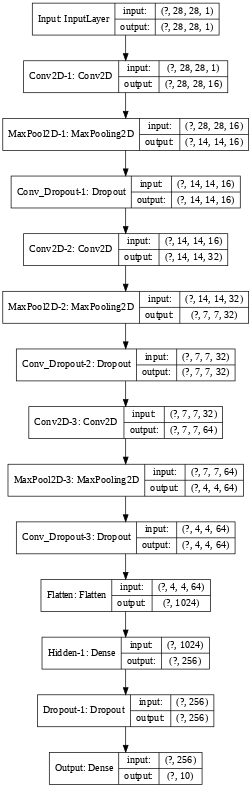

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 3s 59us/step - loss: 0.7257 - accuracy: 0.7270 - val_loss: 0.4783 - val_accuracy: 0.8068
Epoch 2/100
54000/54000 [==============================] - 3s 53us/step - loss: 0.4471 - accuracy: 0.8348 - val_loss: 0.3596 - val_accuracy: 0.8633
Epoch 3/100
54000/54000 [==============================] - 3s 53us/step - loss: 0.3833 - accuracy: 0.8574 - val_loss: 0.3233 - val_accuracy: 0.8765
Epoch 4/100
54000/54000 [==============================] - 3s 52us/step - loss: 0.3466 - accuracy: 0.8713 - val_loss: 0.3018 - val_accuracy: 0.8875
Epoch 5/100
54000/54000 [==============================] - 3s 52us/step - loss: 0.3218 - accuracy: 0.8811 - val_loss: 0.2745 - val_accuracy: 0.9000
Epoch 6/100
54000/54000 [==============================] - 3s 53us/step - loss: 0.3068 - accuracy: 0.8862 - val_loss: 0.2681 - val_accuracy: 0.8962
Epoch 7/100
54000/54000 [==============================] - 3s 5

In [ ]:
#call the baseline Model through the train function
cnn_model_adam,cnn_hs_adam=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    epochs=100,
    batch_size=128,
    model_params=model_params
)

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(cnn_hs_adam.history['val_accuracy']) 
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(cnn_hs_adam.history['val_accuracy']))

Best epoch= 33
Best val_accuracy= 0.9308333396911621


In [ ]:
#print results at last epoch
print_results(cnn_hs_adam,cnn_model_adam,best_epoch=best_epoch)

Train Loss     : 0.16441
Validation Loss: 0.19790
Test Loss: 0.21503
-------
Train Accuracy     : 0.93700
Validation Accuracy: 0.93083
Test Accuracy: 0.92330


TRUE! we see an improvement

### Using Batch Normalization

------------------
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Batch_Normalization-1 (Batch (None, 28, 28, 16)        112       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
Conv_Dropout-1 (Dropout)     (None, 14, 14, 16)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
Batch_Normalization-2 (Batch (None, 14, 

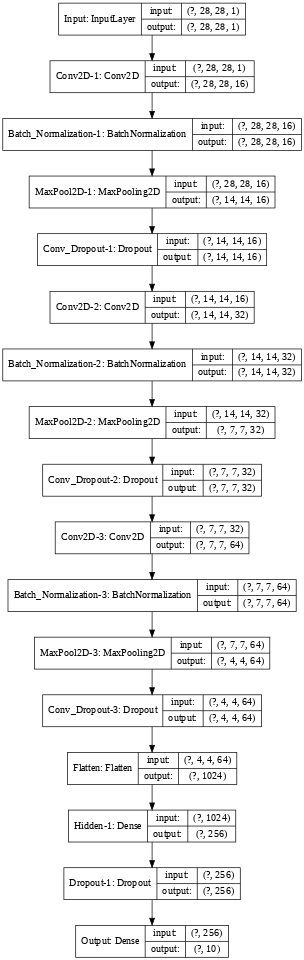

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 6s 108us/step - loss: 0.5480 - accuracy: 0.7935 - val_loss: 0.9263 - val_accuracy: 0.6797
Epoch 2/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.3444 - accuracy: 0.8708 - val_loss: 0.2876 - val_accuracy: 0.8917
Epoch 3/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.3016 - accuracy: 0.8873 - val_loss: 0.2713 - val_accuracy: 0.9012
Epoch 4/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.2771 - accuracy: 0.8961 - val_loss: 0.2866 - val_accuracy: 0.8942
Epoch 5/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.2604 - accuracy: 0.9025 - val_loss: 0.2537 - val_accuracy: 0.9060
Epoch 6/100
54000/54000 [==============================] - 5s 93us/step - loss: 0.2477 - accuracy: 0.9084 - val_loss: 0.2373 - val_accuracy: 0.9133
Epoch 7/100
54000/54000 [==============================] - 5s 

In [ ]:
#call the baseline Model through the train function
cnn_model_adam,cnn_hs_adam=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    epochs=100,
    batch_size=128,
    model_params=model_params
)

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(cnn_hs_adam.history['val_accuracy']) 
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(cnn_hs_adam.history['val_accuracy']))

Best epoch= 41
Best val_accuracy= 0.9313333630561829


In [ ]:
#print results at last epoch
print_results(cnn_hs_adam,cnn_model_adam,best_epoch=best_epoch)

Train Loss     : 0.11879
Validation Loss: 0.21890
Test Loss: 0.24483
-------
Train Accuracy     : 0.95476
Validation Accuracy: 0.93133
Test Accuracy: 0.92740


### Remove Conv_Dropout

------------------
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Batch_Normalization-1 (Batch (None, 28, 28, 16)        112       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
Conv_Dropout-1 (Dropout)     (None, 14, 14, 16)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
Batch_Normalization-2 (Batch (None, 14, 

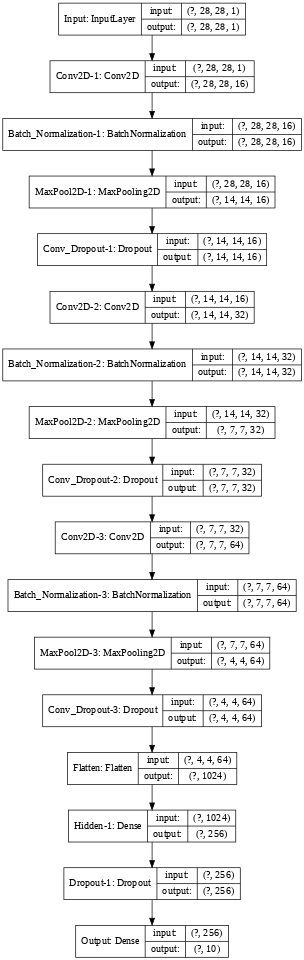

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 6s 108us/step - loss: 0.5480 - accuracy: 0.7944 - val_loss: 0.8812 - val_accuracy: 0.6907
Epoch 2/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.3413 - accuracy: 0.8727 - val_loss: 0.2992 - val_accuracy: 0.8827
Epoch 3/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.3015 - accuracy: 0.8886 - val_loss: 0.2679 - val_accuracy: 0.8990
Epoch 4/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.2754 - accuracy: 0.8974 - val_loss: 0.2743 - val_accuracy: 0.9007
Epoch 5/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.2600 - accuracy: 0.9036 - val_loss: 0.2574 - val_accuracy: 0.9057
Epoch 6/100
54000/54000 [==============================] - 5s 91us/step - loss: 0.2468 - accuracy: 0.9074 - val_loss: 0.2328 - val_accuracy: 0.9150
Epoch 7/100
54000/54000 [==============================] - 5s 

In [ ]:
#call the baseline Model through the train function
cnn_model_adam,cnn_hs_adam=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    epochs=100,
    batch_size=128,
    model_params=model_params
)

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(cnn_hs_adam.history['val_accuracy']) 
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(cnn_hs_adam.history['val_accuracy']))

Best epoch= 28
Best val_accuracy= 0.9301666617393494


In [ ]:
#print results at last epoch
print_results(cnn_hs_adam,cnn_model_adam,best_epoch=best_epoch)

Train Loss     : 0.14260
Validation Loss: 0.21682
Test Loss: 0.23236
-------
Train Accuracy     : 0.94633
Validation Accuracy: 0.93017
Test Accuracy: 0.92400


In [ ]:
# The accuracy dropped .

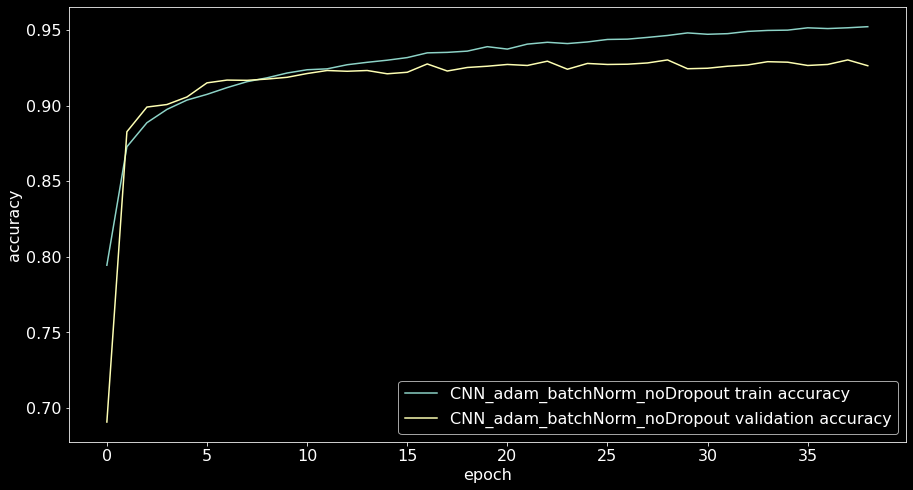

In [ ]:
viz_history(hs_dict={'CNN_adam_batchNorm_noDropout':cnn_hs_adam},metric='accuracy')

### Fine tuning with Keras-Tuner

In [ ]:
!pip install keras-tuner

In [ ]:
import kerastuner as kt

In [ ]:
def tune_model(hp):
    input = tf.keras.Input(
          shape=input_shape,
          name='Input'
      )

    x = input
    # Define the convolutional layers.
    for i in range(model_params['conv_layers']):
        x = tf.keras.layers.Conv2D(
            filters=16*(2**i),
            kernel_size=model_params['kernel_size'],
            strides=model_params['strides'],
            padding='same',
            dilation_rate=(1, 1),
            activation=model_params['conv_activation'],
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)


        if model_params['batch_normalization']:
            x = tf.keras.layers.BatchNormalization(axis=2,name='Batch_Normalization-{0:d}'.format(i + 1)
                                )(x)


        x = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if model_params['conv_dropout']:
            x = tf.keras.layers.Dropout(
                rate=model_params['conv_dropout'],
                name='Conv_Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = tf.keras.layers.Flatten(name='Flatten')(x)

    hp_units = hp.Choice('hidden_units',values=[128])
    hp_hidden_layers=hp.Choice('hidden_layers',values=[1])
    hp_hidden_activation=hp.Choice('hidden_activation',values=['relu'])
    hp_dropout=hp.Choice('dropout',values=[0.2])
    # Define the remaining hidden layers.
    for i in range( hp_hidden_layers):
        x = tf.keras.layers.Dense(
            units=hp_units,
            kernel_initializer='glorot_uniform',
            activation=hp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        x = tf.keras.layers.Dropout(
              rate=hp_dropout,
              name='Dropout-{0:d}'.format(i + 1)
          )(x)
        
    # Define the output layer.
    output = tf.keras.layers.Dense(
        units=10,
        kernel_initializer='uniform',
        activation='softmax',
        name='Output'
    )(x)

    # Define the model and train it.
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.SGD(
                hp.Float(
                    'lr',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3),
                    momentum=0.9,
                    nesterov=True),
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])
    return model

    


In [ ]:
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 1

!rm -R /content/tune_model


In [ ]:
tuner_adam = kt.RandomSearch(tune_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    project_name='tune_model',
    seed=1

)

In [ ]:
tuner_adam.search_space_summary()

In [ ]:
tuner_adam.search(X_train,
             y_train,
             validation_split=0.1,
             epochs=50,
             batch_size=256,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True)])

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.4201 - accuracy: 0.4700 - val_loss: 2.1649 - val_accuracy: 0.2437
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 0.8699 - accuracy: 0.6706 - val_loss: 1.3070 - val_accuracy: 0.5832
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7221 - accuracy: 0.7239 - val_loss: 0.6694 - val_accuracy: 0.7558
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6616 - accuracy: 0.7472 - val_loss: 0.5679 - val_accuracy: 0.7817
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6213 - accuracy: 0.7629 - val_loss: 0.5167 - val_accuracy: 0.8022
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5862 - accuracy: 0.7768 - val_loss: 0.4975 - val_accuracy: 0.8132
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5619 - accuracy: 0.7873 - val_loss: 0.4611 - val_accuracy: 0.8270

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 2.0580 - accuracy: 0.2533 - val_loss: 2.2578 - val_accuracy: 0.1008
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 1.6080 - accuracy: 0.4232 - val_loss: 1.7906 - val_accuracy: 0.4297
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 1.3611 - accuracy: 0.4834 - val_loss: 1.3039 - val_accuracy: 0.5630
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 1.2302 - accuracy: 0.5250 - val_loss: 1.1346 - val_accuracy: 0.5970
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 1.1436 - accuracy: 0.5528 - val_loss: 1.0471 - val_accuracy: 0.6218
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 1.0828 - accuracy: 0.5797 - val_loss: 0.9871 - val_accuracy: 0.6345
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 1.0360 - accuracy: 0.5974 - val_loss: 0.9340 - val_accuracy: 0.6502

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.7037 - accuracy: 0.3807 - val_loss: 2.2248 - val_accuracy: 0.2065
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 1.1181 - accuracy: 0.5653 - val_loss: 1.6423 - val_accuracy: 0.5045
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9347 - accuracy: 0.6446 - val_loss: 0.8969 - val_accuracy: 0.7262
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.8200 - accuracy: 0.6906 - val_loss: 0.6850 - val_accuracy: 0.7525
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7575 - accuracy: 0.7126 - val_loss: 0.6215 - val_accuracy: 0.7788
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7076 - accuracy: 0.7309 - val_loss: 0.5853 - val_accuracy: 0.7868
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6746 - accuracy: 0.7455 - val_loss: 0.5540 - val_accuracy: 0.7942

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.4970 - accuracy: 0.4524 - val_loss: 2.0226 - val_accuracy: 0.3080
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9537 - accuracy: 0.6401 - val_loss: 1.1874 - val_accuracy: 0.6798
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7766 - accuracy: 0.7102 - val_loss: 0.6895 - val_accuracy: 0.7522
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6978 - accuracy: 0.7344 - val_loss: 0.5854 - val_accuracy: 0.7733
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6533 - accuracy: 0.7497 - val_loss: 0.5526 - val_accuracy: 0.7875
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6170 - accuracy: 0.7649 - val_loss: 0.5205 - val_accuracy: 0.8028
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5918 - accuracy: 0.7735 - val_loss: 0.5016 - val_accuracy: 0.8113

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 0.8867 - accuracy: 0.6611 - val_loss: 2.0961 - val_accuracy: 0.1632
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5408 - accuracy: 0.7957 - val_loss: 0.7169 - val_accuracy: 0.7392
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 0.4587 - accuracy: 0.8306 - val_loss: 0.3878 - val_accuracy: 0.8530
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.4155 - accuracy: 0.8469 - val_loss: 0.3339 - val_accuracy: 0.8725
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.3874 - accuracy: 0.8588 - val_loss: 0.3208 - val_accuracy: 0.8777
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.3646 - accuracy: 0.8664 - val_loss: 0.2977 - val_accuracy: 0.8873
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.3466 - accuracy: 0.8728 - val_loss: 0.2959 - val_accuracy: 0.8905

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.4527 - accuracy: 0.4570 - val_loss: 2.0122 - val_accuracy: 0.3350
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9064 - accuracy: 0.6518 - val_loss: 1.1717 - val_accuracy: 0.6485
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7497 - accuracy: 0.7150 - val_loss: 0.6487 - val_accuracy: 0.7668
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6744 - accuracy: 0.7427 - val_loss: 0.5551 - val_accuracy: 0.7847
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6333 - accuracy: 0.7592 - val_loss: 0.5200 - val_accuracy: 0.7988
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5980 - accuracy: 0.7714 - val_loss: 0.4864 - val_accuracy: 0.8098
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5714 - accuracy: 0.7830 - val_loss: 0.4673 - val_accuracy: 0.8195

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.8316 - accuracy: 0.3538 - val_loss: 2.2031 - val_accuracy: 0.2233
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 1.2394 - accuracy: 0.5330 - val_loss: 1.5581 - val_accuracy: 0.6037
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 1.0445 - accuracy: 0.5982 - val_loss: 0.9937 - val_accuracy: 0.7028
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9260 - accuracy: 0.6478 - val_loss: 0.7990 - val_accuracy: 0.7293
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.8358 - accuracy: 0.6856 - val_loss: 0.7045 - val_accuracy: 0.7530
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7706 - accuracy: 0.7090 - val_loss: 0.6500 - val_accuracy: 0.7630
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7317 - accuracy: 0.7222 - val_loss: 0.6150 - val_accuracy: 0.7683

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.9252 - accuracy: 0.3090 - val_loss: 2.2592 - val_accuracy: 0.1612
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 1.3372 - accuracy: 0.4967 - val_loss: 1.7421 - val_accuracy: 0.4692
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 1.1159 - accuracy: 0.5613 - val_loss: 1.1066 - val_accuracy: 0.6018
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9982 - accuracy: 0.6146 - val_loss: 0.9000 - val_accuracy: 0.6628
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9130 - accuracy: 0.6547 - val_loss: 0.8002 - val_accuracy: 0.7095
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.8435 - accuracy: 0.6813 - val_loss: 0.7351 - val_accuracy: 0.7312
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.7936 - accuracy: 0.7009 - val_loss: 0.6854 - val_accuracy: 0.7473

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.8566 - accuracy: 0.3413 - val_loss: 2.1887 - val_accuracy: 0.2238
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 1.2977 - accuracy: 0.5076 - val_loss: 1.5052 - val_accuracy: 0.5553
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 1.1212 - accuracy: 0.5619 - val_loss: 1.0434 - val_accuracy: 0.6345
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 1.0246 - accuracy: 0.6011 - val_loss: 0.9030 - val_accuracy: 0.6592
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9535 - accuracy: 0.6336 - val_loss: 0.8263 - val_accuracy: 0.7007
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.8907 - accuracy: 0.6628 - val_loss: 0.7587 - val_accuracy: 0.7333
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.8280 - accuracy: 0.6912 - val_loss: 0.7029 - val_accuracy: 0.7502

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 1.0166 - accuracy: 0.6193 - val_loss: 2.1100 - val_accuracy: 0.1098
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 0.6126 - accuracy: 0.7686 - val_loss: 0.9967 - val_accuracy: 0.6933
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 0.5342 - accuracy: 0.8005 - val_loss: 0.4664 - val_accuracy: 0.8387
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 0.4877 - accuracy: 0.8199 - val_loss: 0.3813 - val_accuracy: 0.8572
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 0.4497 - accuracy: 0.8352 - val_loss: 0.3587 - val_accuracy: 0.8650
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.4274 - accuracy: 0.8430 - val_loss: 0.3346 - val_accuracy: 0.8702
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.4019 - accuracy: 0.8517 - val_loss: 0.3274 - val_accuracy: 0.8770

Epoch 1/50
211/211 [==============================] - 3s 14ms/step - loss: 2.0137 - accuracy: 0.2826 - val_loss: 2.2555 - val_accuracy: 0.2515
Epoch 2/50
211/211 [==============================] - 3s 13ms/step - loss: 1.4609 - accuracy: 0.4714 - val_loss: 1.7418 - val_accuracy: 0.4173
Epoch 3/50
211/211 [==============================] - 3s 13ms/step - loss: 1.2287 - accuracy: 0.5235 - val_loss: 1.2052 - val_accuracy: 0.5873
Epoch 4/50
211/211 [==============================] - 3s 13ms/step - loss: 1.1137 - accuracy: 0.5613 - val_loss: 1.0210 - val_accuracy: 0.6300
Epoch 5/50
211/211 [==============================] - 3s 13ms/step - loss: 1.0393 - accuracy: 0.5927 - val_loss: 0.9323 - val_accuracy: 0.6612
Epoch 6/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9694 - accuracy: 0.6254 - val_loss: 0.8552 - val_accuracy: 0.6857
Epoch 7/50
211/211 [==============================] - 3s 13ms/step - loss: 0.9091 - accuracy: 0.6534 - val_loss: 0.7885 - val_accuracy: 0.7202

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_params=tuner_adam.get_best_hyperparameters()[0].values
best_params

{'dropout': 0.2,
 'hidden_activation': 'relu',
 'hidden_layers': 2,
 'hidden_units': 256,
 'lr': 0.008520876742029873}

### Fine Tuned CNN Model

In [ ]:
model_params={'conv_dropout':0.2,
              'conv_layers':3,
              'conv_activation':'relu',
              'kernel_size':(3, 3),
              'strides':(1, 1),
              'batch_normalization':True,
              'dropout':True,
              'hidden_units':256,
              'hidden_layers':1,
              'hidden_activation':'relu',
              'lr':0.0085,
              'learning_rate':0.001,
              }

------------------
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
Batch_Normalization-1 (Batch (None, 28, 28, 16)        112       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
Conv_Dropout-1 (Dropout)     (None, 14, 14, 16)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
Batch_Normalization-2 (Batch (None, 14, 

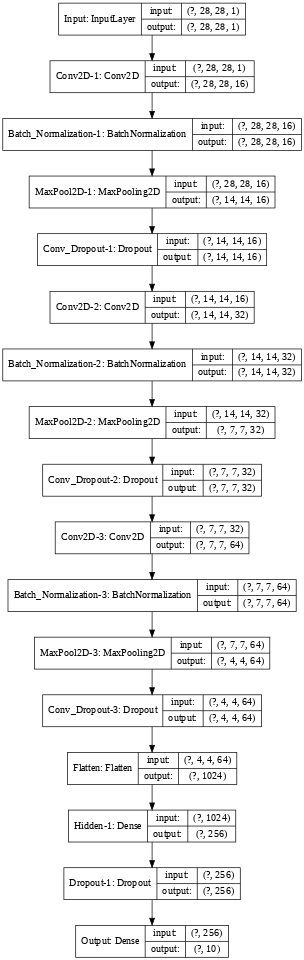

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 9s 166us/step - loss: 0.6842 - accuracy: 0.7448 - val_loss: 2.2319 - val_accuracy: 0.0942
Epoch 2/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.3996 - accuracy: 0.8520 - val_loss: 2.1255 - val_accuracy: 0.2313
Epoch 3/100
54000/54000 [==============================] - 2s 40us/step - loss: 0.3358 - accuracy: 0.8740 - val_loss: 1.5665 - val_accuracy: 0.4468
Epoch 4/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.3039 - accuracy: 0.8855 - val_loss: 0.9641 - val_accuracy: 0.6862
Epoch 5/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.2821 - accuracy: 0.8945 - val_loss: 0.5473 - val_accuracy: 0.8033
Epoch 6/100
54000/54000 [==============================] - 2s 39us/step - loss: 0.2643 - accuracy: 0.9018 - val_loss: 0.3168 - val_accuracy: 0.8820
Epoch 7/100
54000/54000 [==============================] - 2s 

In [ ]:
#call the CNN Model through the train function
cnn_model_tuned_adam,cnn_hs_tuned_adam=train_model(
    train_data=X_train,
    train_labels=y_train,
    optimizer=Adam,
    epochs=100,
    batch_size=512,
    model_params=model_params
)

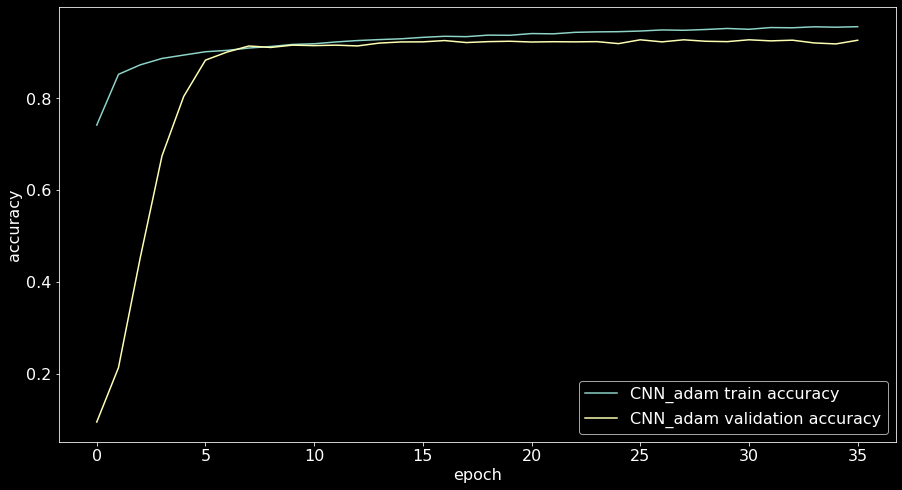

In [ ]:
viz_history(hs_dict={'CNN_adam':cnn_hs_tuned_adam},metric='accuracy')

In [ ]:
# Find the scores from the epochs according to Early stopping
best_epoch = np.argmax(cnn_hs_tuned_adam.history['val_accuracy']) 
print('Best epoch=',best_epoch)
print('Best val_accuracy=',np.max(cnn_hs_tuned_adam.history['val_accuracy']))

Best epoch= 21
Best val_accuracy= 0.9269999861717224


In [ ]:
#print results at best epoch
print_results(cnn_hs_tuned_adam,cnn_model_tuned_adam,best_epoch=best_epoch)

Train Loss     : 0.15153
Validation Loss: 0.21061
Test Loss: 0.22188
-------
Train Accuracy     : 0.94257
Validation Accuracy: 0.92700
Test Accuracy: 0.92910


### Model Assesment

In [ ]:
import pandas as pd

In [ ]:
predictions=cnn_model_tuned_adam.predict(X_test)
predicted_classes=np.argmax(predictions,axis=1)

In [ ]:


p = predicted_classes[:10000]
y = test_labels[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]



In [ ]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9291
Incorrect predicted classes: 709


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

In [ ]:
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

In [ ]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(10)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.87      0.89      0.88      1000
    Class 1 (Trouser) :       0.99      0.98      0.99      1000
   Class 2 (Pullover) :       0.89      0.90      0.89      1000
      Class 3 (Dress) :       0.93      0.93      0.93      1000
       Class 4 (Coat) :       0.88      0.89      0.88      1000
     Class 5 (Sandal) :       0.99      0.99      0.99      1000
      Class 6 (Shirt) :       0.79      0.75      0.77      1000
    Class 7 (Sneaker) :       0.96      0.98      0.97      1000
        Class 8 (Bag) :       0.99      0.98      0.99      1000
 Class 9 (Ankle Boot) :       0.98      0.96      0.97      1000

               accuracy                           0.93     10000
              macro avg       0.93      0.93      0.93     10000
           weighted avg       0.93      0.93      0.93     10000





The best accuracy is obtained for Class 1, Class 5, Class 8, Class 9 and Class 7. Worst accuracy is for Class 6.

The recall is highest for Class 8, Class 5 and smallest for Class 6 and Class 4.

f1-score is highest for Class 1, Class 5 and Class 8 and smallest for Class 6 followed by Class 4 and Class 2.





In [ ]:
cm=confusion_matrix(test_labels,predicted_classes)
cm2df(cm, labels.values())

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle Boot
T-shirt/top,870,0,19,10,1,1,96,0,3,0
Trouser,1,990,0,4,1,0,3,0,1,0
Pullover,16,1,897,8,34,0,44,0,0,0
Dress,12,5,8,933,21,0,21,0,0,0
Coat,0,1,43,21,886,0,49,0,0,0
Sandal,0,0,0,0,0,986,0,11,0,3
Shirt,79,2,50,22,51,0,794,0,2,0
Sneaker,0,0,0,0,0,5,0,984,0,11
Bag,1,0,0,5,1,1,4,3,985,0
Ankle Boot,0,0,0,0,0,4,1,29,0,966


We can see that the Shirt which has the lowest accuracy is mostly confused with the T-shirt/top,the Pullover and the Dress. 